In [30]:
import argparse
import os
import os.path as osp
import time
import warnings

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)

from mmdet.apis import multi_gpu_test, single_gpu_test
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.utils import (build_ddp, build_dp, compat_cfg, get_device,
                         setup_multi_processes, update_data_root)
from mmcv.parallel import MMDataParallel

In [31]:
cfg = Config.fromfile('./swin_faster_cfg.py')

cfg.work_dir = '../work_dirs/all-seaing-eye'
cfg.data.test.test_mode = True

In [32]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=8,
        workers_per_gpu=8,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [33]:
checkpoint_path = os.path.join(cfg.work_dir, 'best_bbox_mAP_epoch_10.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

load checkpoint from local path: ../work_dirs/all-seaing-eye/best_bbox_mAP_epoch_10.pth


In [34]:
output = single_gpu_test(model, data_loader)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 197/197, 28.7 task/s, elapsed: 7s, ETA:     0s

In [35]:
output

[[array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32)],
 [array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32)],
 [array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32)],
 [array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32)],
 [array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32)],
 [array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32)],
 [array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32)],
 [array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([], shape=(0, 5), d

In [36]:
output_with_bbox = []
for i in range(len(output)):
    try:
        output[i][0][0]
    except IndexError:
        continue
    else:
        output_with_bbox.append(i)

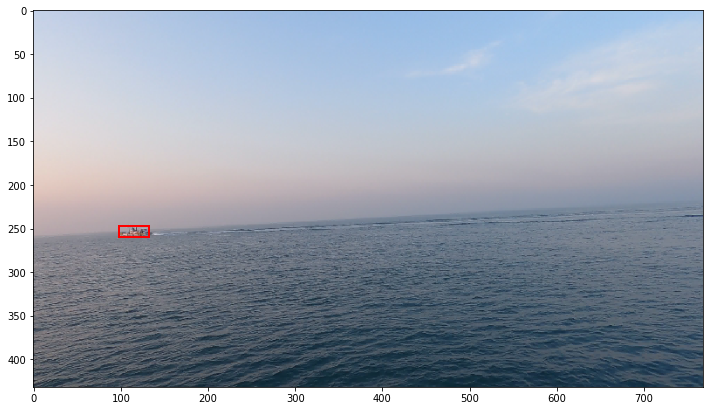

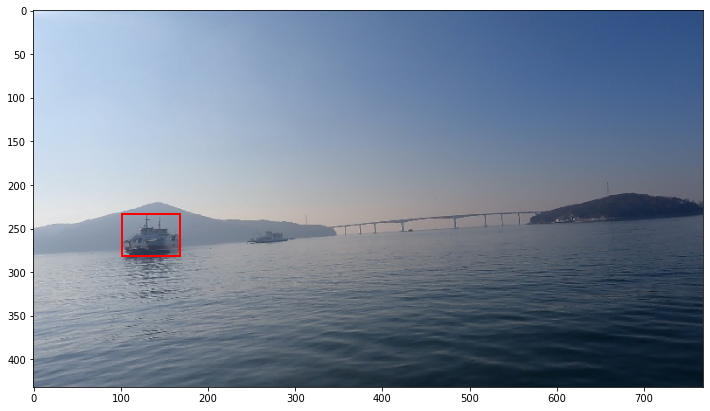

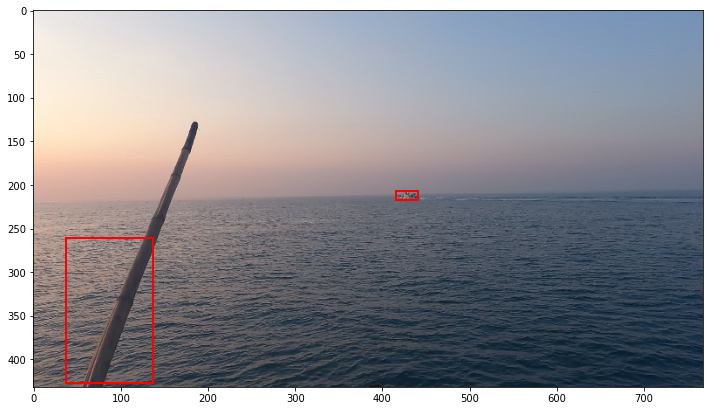

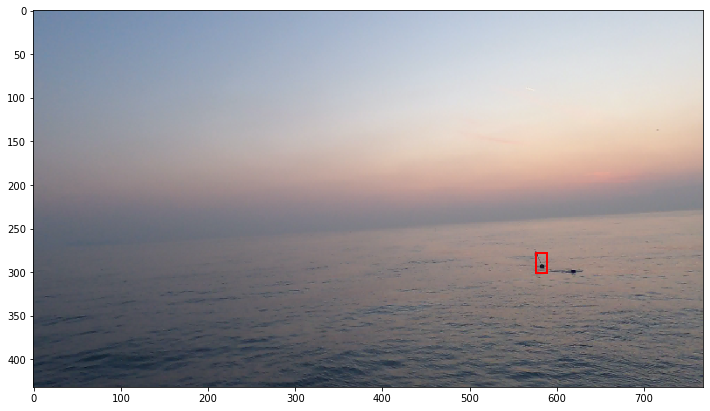

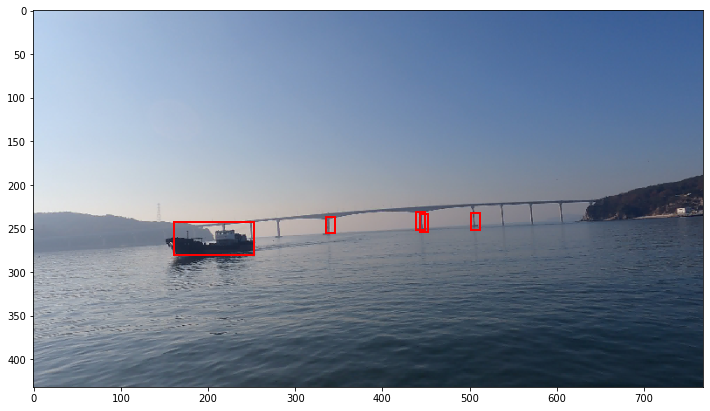

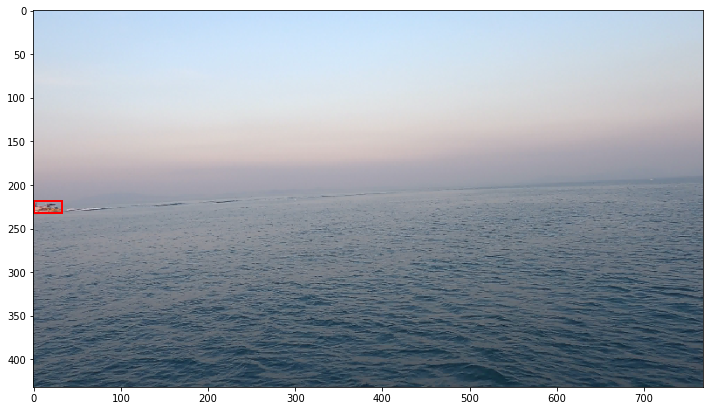

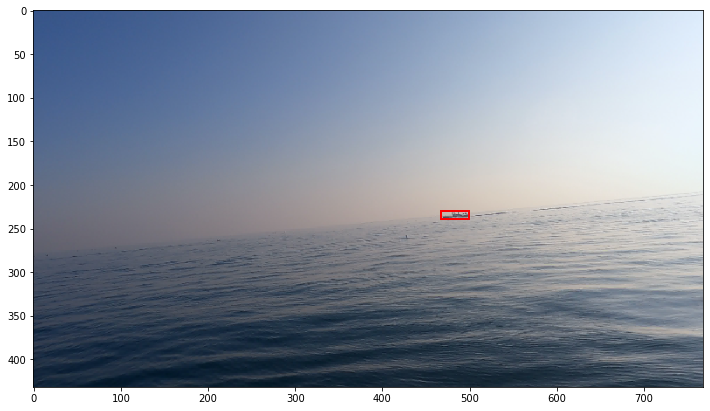

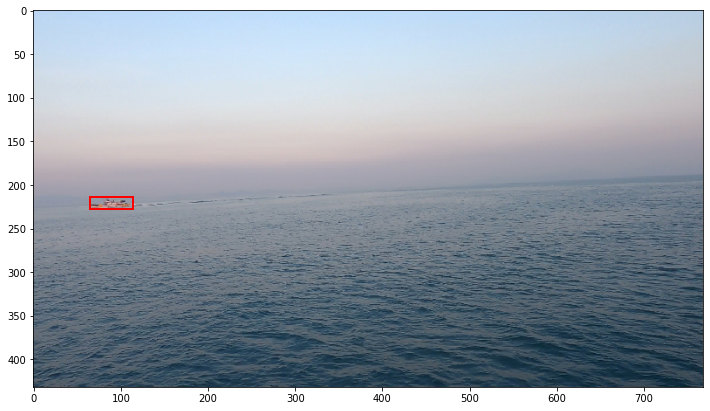

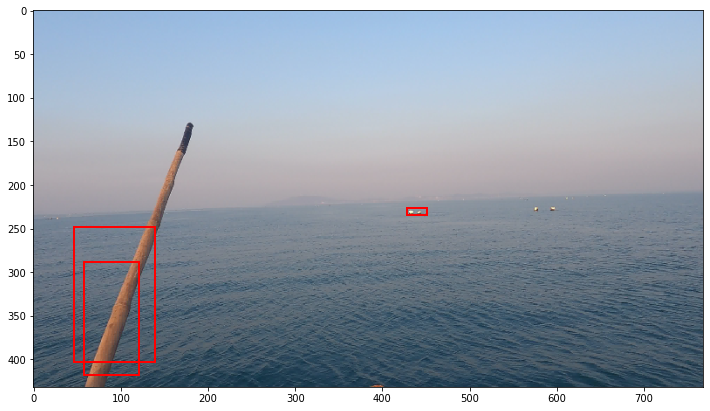

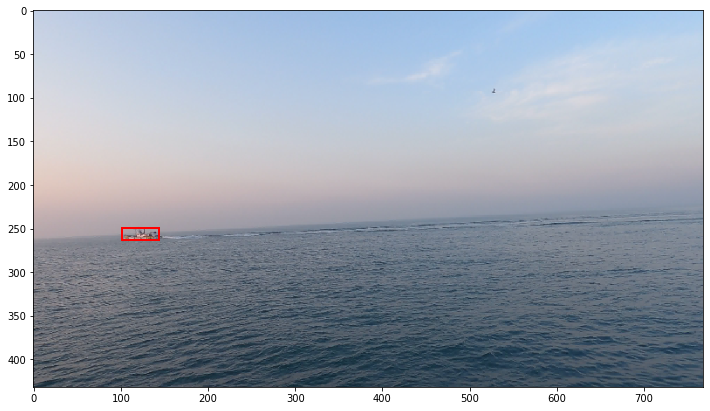

In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

random.shuffle(output_with_bbox)
output_with_bbox = output_with_bbox[:10]

for i in output_with_bbox:
    img = dataset[i]['img'][0].numpy()
    
    min_ = np.min(img)
    max_ = np.max(img)
    
    img = img - (max_+min_)/2
    img = img / (max_-min_)
    img = img + 0.5
    
    img = np.transpose(img, (1, 2, 0))
    img = img[0:cfg.img_scale[1], 0:cfg.img_scale[0]]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    for j in range(len(output[i][0])):
        l, t, r, b, c = output[i][0][j]
        l, t, r, b, c = int(l)/5, int(t)/5, int(r)/5, int(b)/5, int(c)/5

        rect = mpl.patches.Rectangle((l, t), r-l, b-t, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
    plt.imshow(img)
    plt.show()